## Assignment A3b: Filtering

### 1a. A moving average filter

According to the definition we can get:

\begin{align} 
y_M[n]&=\frac{1}{M} \sum_{k=0}^{M-1}x[n-k] \\
&=\frac{1}{M}(x[n] + x[n-1] + \cdot\cdot\cdot + x[n-(M-1)])
\end{align}

And then you need to note that

\begin{align} 
y_{M-1}[n-1]&=\frac{1}{M-1} \sum_{k=0}^{M-2}x[(n-1)-k] \\
&=\frac{1}{M-1}(x[n-1] + \cdot\cdot\cdot + x[(n-1)-(M-2)]) \\
&=\frac{1}{M-1}(x[n-1] + \cdot\cdot\cdot + x[n-M+1]) \\
\end{align}

#### Substituting this expression in the first summation yields

\begin{align} 
y_{M}[n]&=\frac{1}{M}(x[n] + (M-1)y_{M-1}[n-1]) \\
&=\frac{M-1}{M}y_{M-1}[n-1]+\frac{1}{M}x[n] \\
\end{align}

Finally, because

\begin{align} 
1 - \frac{M-1}{M} = \frac{1}{M}
\end{align}

and letting $\lambda = (M - 1)/M$ we can get that

\begin{align} 
\lambda y_{M-1}[n-1] + (1-\lambda)x[n]
\end{align}

As lambda becomes larger, the weight of the current input is reduced, and so the smoothing is larger. For $\lambda = 0$, it simply the input and there is no smoothing at all.

### 1b. Implementation

#### Write a function movingavg and randprocess

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import librosa
import librosa.display
from copy import deepcopy,copy
from scipy.io.wavfile import read
import scipy.io.wavfile
from IPython.display import display,Latex
from pylab import *
from scipy.io import wavfile
import wave
import random
import h5py

def randprocess(N,sigma=1):
    y=[]
    for i in range(0,N):
        if i==0:
            a=0
        else:
            a=np.random.normal(y[i-1],sigma)
        y.append(a)
    return y

def movingavg(x,lam=0.5):
    y=[]
    for i in range(len(x)):
        if i == 0:
            yn_1=0
        else:
            yn_1=y[-1]
        yn=lam*yn_1+(1-lam)*x[i]
        y.append(yn)
    return y

#### Test function using random noise

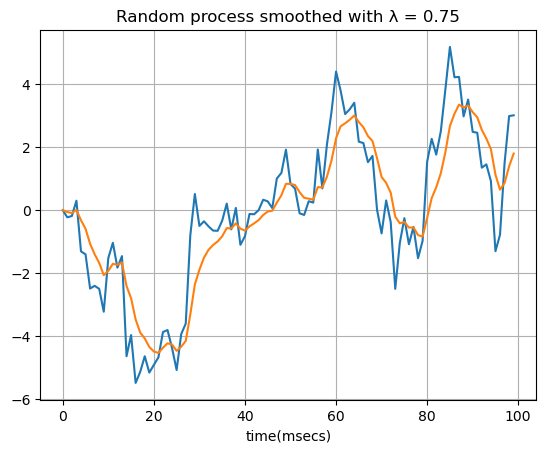

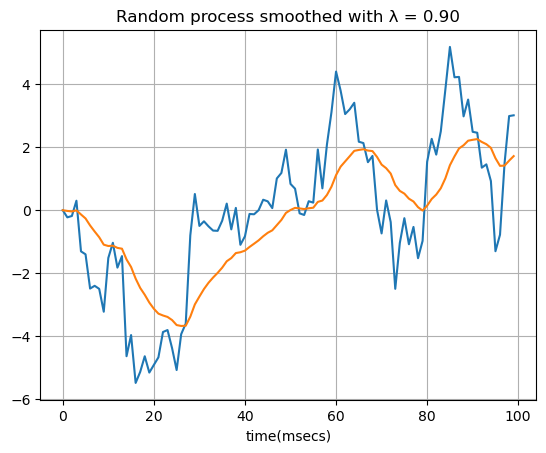

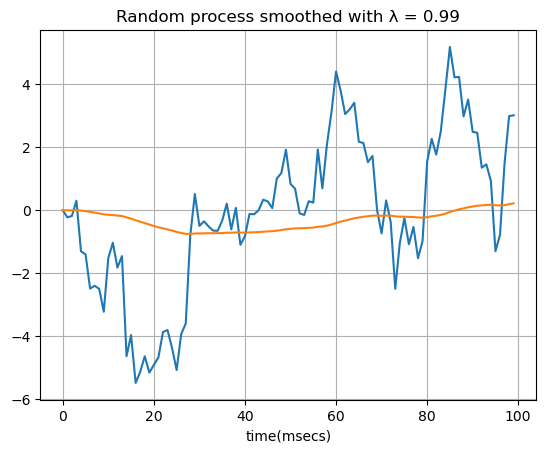

In [2]:
y=randprocess(100,sigma=1)
for lam in [0.75,0.9,0.99]:
    y_new=movingavg(y,lam)
    plt.figure()
    plt.plot(y)
    plt.plot(y_new)
    plt.title('Random process smoothed with λ = %.2f'%lam)
    plt.xlabel('time(msecs)')
    plt.grid()
    plt.show()

#### Test function using noisy sinewave

In [3]:
def sinewave(t,f,phi):
    return np.sin(2*np.pi*f*t+phi) 
def timetoindex(t,fs):
    return int(t*fs)
def noisysignal(t,g,tau,T,sigma_noise=0.1,fs=100,f=1,phi=0,sigma=1,n=4,tscale=1,tunits='secs',plot=True):
    if g=='sin':
        x=np.linspace(0,T,1000,endpoint=True)
        y=np.vectorize(sinewave)(x,f,phi)        
    if g=='gammatone':
        x=np.linspace(0,T,400,endpoint=True)
        y=np.vectorize(gammatone)(x,fs,f)        
    if g=='step':
        x,y=step(0,T,1000)
    if g=='delta':
        x,y=delta(0,T,1000,fs)
    
    x=x+tau
    for i in range(int(tau*1000)):
        y=np.insert(y,0,0)
        x=np.insert(x,0,1/1000*(int(tau*1000)-i-1))
    l=tau+T
    for i in range(int((t-tau-T)*1000)):
        l+=1/1000
        y=np.insert(y,len(y),0)
        x=np.insert(x,len(x),l)
    if plot==True:
        if tunits == 'secs':
            plt.xlabel('time(secs)')
        else:
            plt.xlabel('time(msecs)')
            x*=tscale
        
    a=len(x)
    index=np.linspace(0,a,timetoindex(t,fs),endpoint=False)
    x_plot=[]
    y_plot=[]
    for i in index:
        x_plot.append(x[int(i)])
        y_plot.append(y[int(i)])
    for i in range(0,len(x_plot)):
        y_plot[i]+=random.gauss(0,sigma_noise)
    if plot==True:
        if g=='delta':
            for i in range(0,len(y_plot)):
                plt.scatter(x_plot[i],y_plot[i],color='green',marker='o')
                plt.plot([x_plot[i],x_plot[i]],[0,y_plot[i]],color='r',linestyle='-')
        if g=='sin' or g=='step' or g=='gammatone':
            for i in range(0,len(y_plot)):
                plt.plot([x_plot[i],x_plot[i]],[0,y_plot[i]],color='r')
        plt.grid()
        plt.show()
    else:
        return x_plot,y_plot

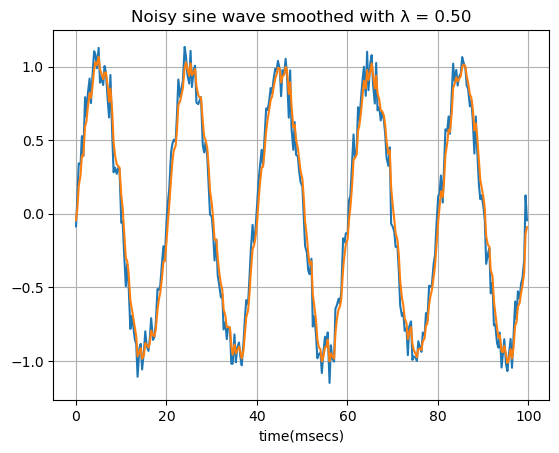

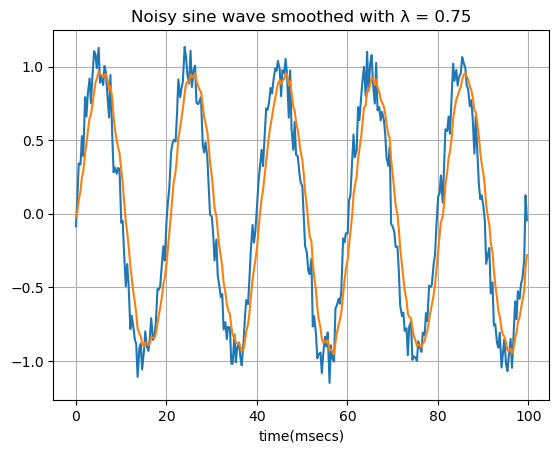

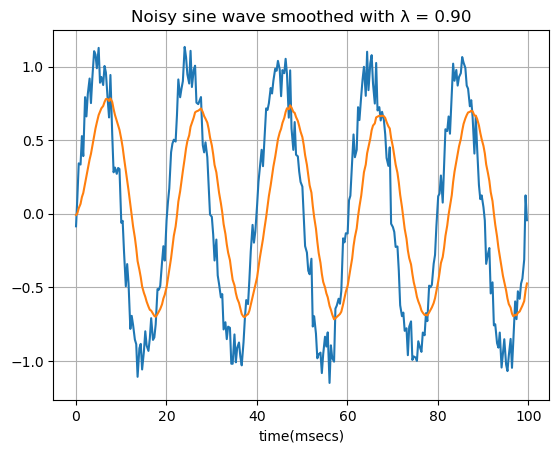

In [4]:
t, y = noisysignal(t = 0.1, g = "sin", tau = 0, T = 0.1, sigma_noise = 0.1, fs = 3000, 
            f = 50, phi = 0, sigma = 0.25, n = 4, tscale = 1000, tunits = "msces", plot = False)
t = np.array(t)
y = np.array(y)
for lam in [0.5,0.75,0.9]:
    y_new=movingavg(y,lam)
    plt.figure()
    plt.plot(t*1000,y)
    plt.plot(t*1000,y_new)
    plt.title('Noisy sine wave smoothed with λ = %.2f'%lam)
    plt.xlabel('time(msecs)')
    plt.grid()
    plt.show()

### 1c. System delay

Since each output is effectively an average of the previous M inputs,the resulting signal is delayed by $(M - 1)/2$ compared to a centralaverage. From the derivation, we can compute $M$ from

\begin{align} 
(1-\lambda)=\frac{1}{M}\implies M=\frac{1}{1-\lambda}  
\end{align}

so we can calculate the effective delays from $\lambda$.

In [5]:
lam_s = np.array([0.5, 0.75, 0.9, 0.99])
M_s = 1.0 / (1.0 - lam_s)
print("lam_s =",lam_s,"M_s =",M_s)

lam_s = [0.5  0.75 0.9  0.99] M_s = [  2.   4.  10. 100.]


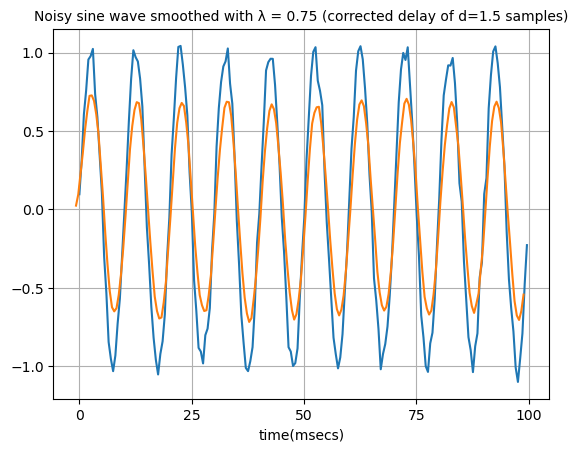

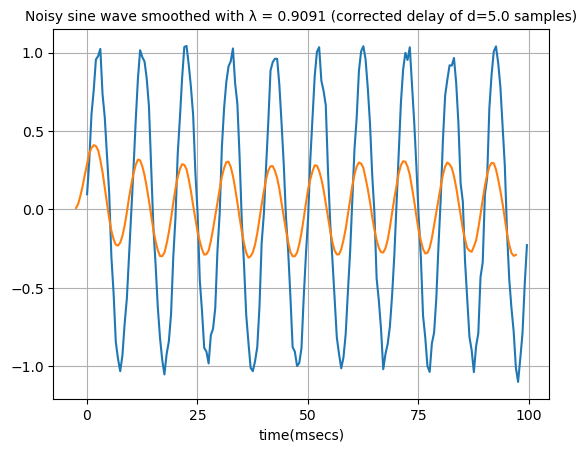

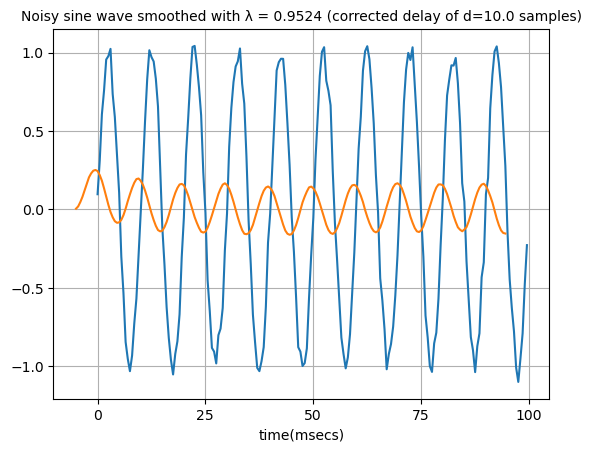

In [6]:
fs = 2000
t = 0.1
sigma = 0.05
t, y = noisysignal(t = 0.1, g = "sin", tau = 0, T = 0.1, sigma_noise = 0.05, fs = 2000,
                   f = 100, phi = 0, sigma = 0.05, n = 4, tscale = 1000, tunits = "msces", 
                   plot = False)
t = np.array(t)
y = np.array(y)
for lam in [0.75,10/11,20/21]:
    y_new=movingavg(y,lam)
    M = 1 / (1 - lam)
    d = (M - 1) / 2
    tau = d / fs
    plt.figure()
    plt.plot(t*1000,y)
    plt.plot((t-tau)*1000,y_new)
    plt.title(f"Noisy sine wave smoothed with λ = {round(lam, 4)} (corrected delay of d={round(d, 2)} samples)",size = 10)
    plt.xlabel('time(msecs)')
    my_x_ticks = np.arange(0, 100.01, 25)
    plt.xticks(my_x_ticks)
    plt.grid()
    plt.show()

### 2a. Implementation

#### Design the function filterIIR

In [7]:
def filterIIR(x,a,b):
    y=[]
    x_temp=[]
    y_temp=[]
    for i in range(len(a)):
        y_temp.append(0)
    for i in range(len(b)-1):
        x_temp.append(0)
    for i in range(len(x)):
        x_temp.insert(0,x[i])
        yn=0
        for j in range(len(a)):
            yn-=a[j]*y_temp[j]
        for j in range(len(b)):
            yn+=b[j]*x_temp[j]
        y.append(yn)
        
        y_temp.insert(0,yn)
        y_temp.pop
        x_temp.pop
    return np.array(y)

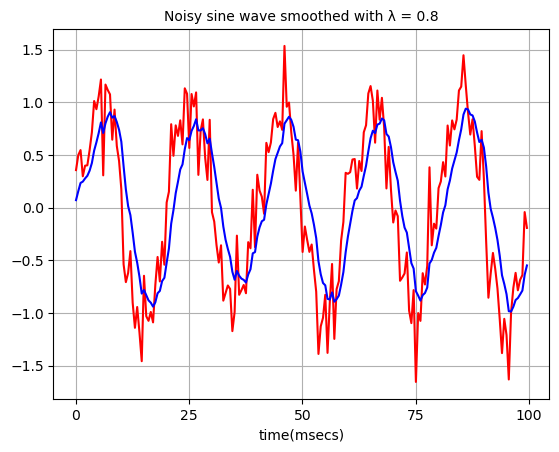

In [62]:
fs = 2000
t = 0.1
sigma = 0.25
t, y = noisysignal(t = 0.1, g = "sin", tau = 0, T = 0.1, sigma_noise = 0.25, fs = 2000,
                   f = 50, phi = 0, sigma = 0.25, n = 4, tscale = 1000, tunits = "msces", 
                   plot = False)
t = np.array(t)
y = np.array(y)
lam = 0.8
yma = movingavg(y, lam)
yma = np.array(yma)
plt.figure()
plt.plot(t*1000, y, color = "r")
plt.plot(t*1000, yma, color = "b")
plt.title(f"Noisy sine wave smoothed with λ = {round(lam, 4)}",size = 10)
plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 100.01, 25)
plt.xticks(my_x_ticks)
plt.grid()
plt.show()

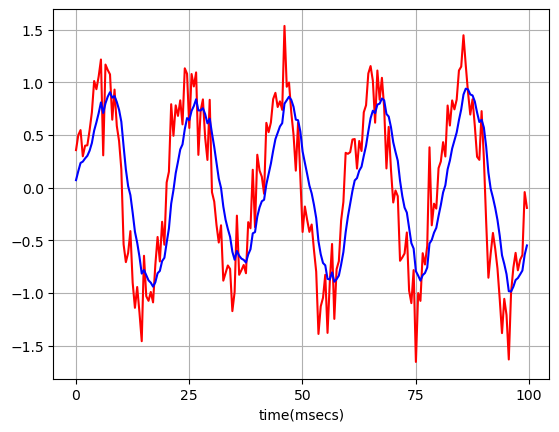

In [63]:
a = [-lam]
b = [1 - lam]
a = np.array(a)
b = np.array(b)
yiir = filterIIR(y, a, b)
plt.figure()
plt.plot(t*1000, y, color = "r")
plt.plot(t*1000, yma, color = "b")
plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 100.01, 25)
plt.xticks(my_x_ticks)
plt.grid()
plt.show()

In [50]:
print("np.sum(yma) =", np.sum(yma))
print("np.sum(yiir) =", np.sum(yiir))
print("np.sum(yiir) - np.sum(yma) =", np.sum(yiir) - np.sum(yma))

np.sum(yma) = -2.4052636823783384
np.sum(yiir) = -2.4052636823783384
np.sum(yiir) - np.sum(yma) = 0.0


### 2b. First order low- and high-pass IIR filters

In [11]:
def randprocess(N,sigma=1):
    y=[]
    for i in range(0,N):
        if i==0:
            a=0
        else:
            a=np.random.normal(y[i-1],sigma)
        y.append(a)
    return y

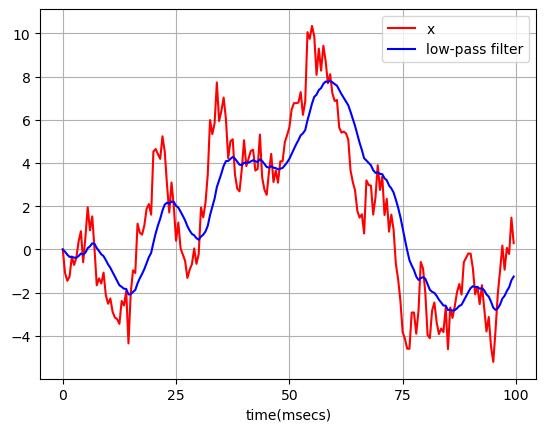

In [60]:
fs = 2000
t = np.arange(0, 0.1, 1/2000)
x = randprocess(N = len(t), sigma = 1)
a = [-0.9]
b = [0.1]
y = filterIIR(x, a, b)
plt.figure()
plt.plot(t*1000, x, color = "r", label = "x")
plt.plot(t*1000, y, color = "b", label = "low-pass filter")
plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 100.01, 25)
plt.xticks(my_x_ticks)
plt.grid()
plt.legend()
plt.show()

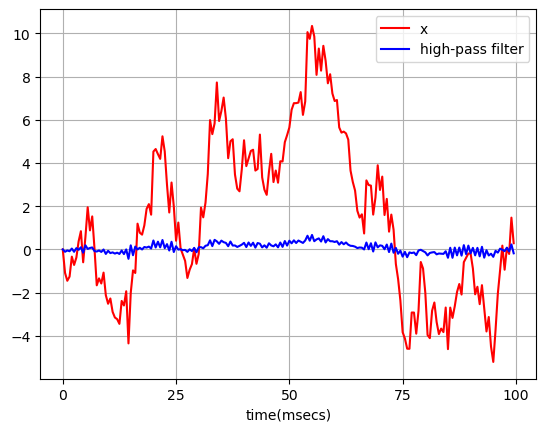

In [61]:
a = [0.9]
b = [0.1]
y = filterIIR(x, a, b)
plt.figure()
plt.plot(t*1000, x, color = "r", label = "x")
plt.plot(t*1000, y, color = "b", label = "high-pass filter")
plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 100.01, 25)
plt.xticks(my_x_ticks)
plt.grid()
plt.legend()
plt.show()

### Answer

The difference equations provided define two types of filters: a low-pass filter and a high-pass filter:
#### Low-pass filter:
$$y[n] = 0.1x[n] + 0.9y[n - 1]$$ 
#### High-pass filter:
$$y[n] = 0.1x[n]  - 0.9y[n - 1]$$ 

The first equation describes a low-pass filter, where the current output y[n] is a weighted sum of the current input x[n] and the previous output y[n-1]. The coefficients 0.1 and 0.9 determine the weights of the current input and previous output, respectively. The filter allows low frequency components of the input signal to pass through while attenuating high frequency components.

The second equation describes a high-pass filter, where the current output y[n] is the difference between the current input x[n] and a weighted sum of the previous output y[n-1]. The coefficient 0.1 determines the weight of the current input, while the coefficient -0.9 determines the weight of the previous output. The filter allows high frequency components of the input signal to pass through while attenuating low frequency components.

### 2c. Second order bandpass filters

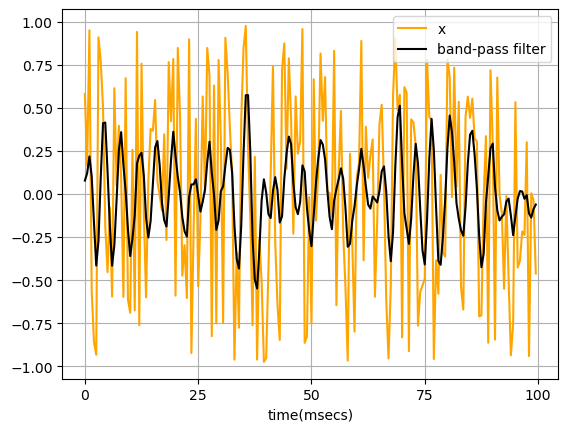

In [14]:
fs = 2000
t = np.arange(0, 0.1, 1/2000)
x = 2 * np.random.rand(len(t)) - 1
a = [-1.265, 0.81]
b = [0.135]
y = filterIIR(x, a, b)
plt.figure()
plot(1000 * t, x, label = "x", color = "orange")
plt.plot(t * 1000, y, color = "black", label = "band-pass filter")
plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 100.01, 25)
plt.xticks(my_x_ticks)
plt.grid()
plt.legend()
plt.show()

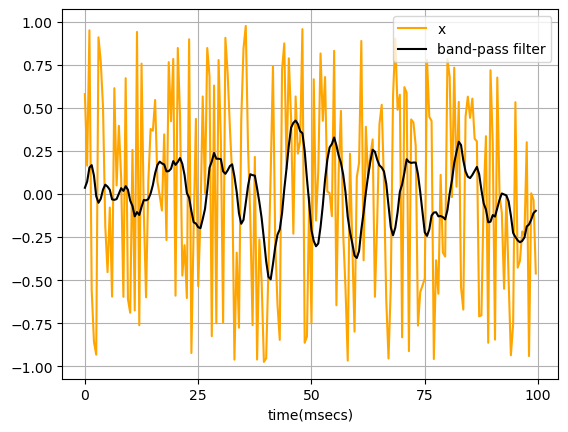

In [15]:
a = [-1.702, 0.81]
b = [0.063]
y = filterIIR(x, a, b)
plt.figure()
plot(1000 * t, x, label = "x", color = "orange")
plt.plot(t * 1000, y, color = "black", label = "band-pass filter")
plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 100.01, 25)
plt.xticks(my_x_ticks)
plt.grid()
plt.legend()
plt.show()

#### The filter equations are:

$$y[n] = 0.135x[n] + 1.265y[n -1] -0.81y[n -2]$$
$$y[n]= 0.063x[n] + 1.702y[n -1] - 0.81y[n -2]$$

They can be seen as a combined low-pass and high-pass filter. Both filters have the same effect as a high-pass filter since they remove the same portion of y[n - 2], but the second example smoothes the signal more and allows lower frequencies to pass.

### 2d. Characterizing the filter response

In [16]:
def noisefreqplot(t, freqs, sigma_s, a, b):
    fig, ax=plt.subplots(4, 4) 
    ylim = (-2, 2)
    xlim = (0, 100)
    for i, sigma_n in enumerate(sigma_s):
        ylabel = "σ = {}".format(sigma_n)
        for j, f_n in enumerate(freqs):
            time, y = noisysignal(t = 0.1, g = "sin", tau = 0,T = 0.1, 
                                  sigma_noise = sigma_n,fs = 2000,f = f_n, 
                                  phi = 0, sigma = 0.05, n = 4,tscale = 1000, 
                                  tunits = "msces",plot = False)            
            s = filterIIR(y, a, b)  
            time = np.array(time)
            ax[i][j].plot(time * 1000, s, linewidth=0.6)
            ax[i][j].set_ylim(ylim) 
            ax[i][j].set_xlim(xlim) 
            if j == 0:
                ax[i][j].set_ylabel(ylabel)
            if i == len(freqs) - 1:                
                xlabel = "f = {}".format(f_n)
                ax[i][j].set_xlabel(xlabel)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    plt.show()

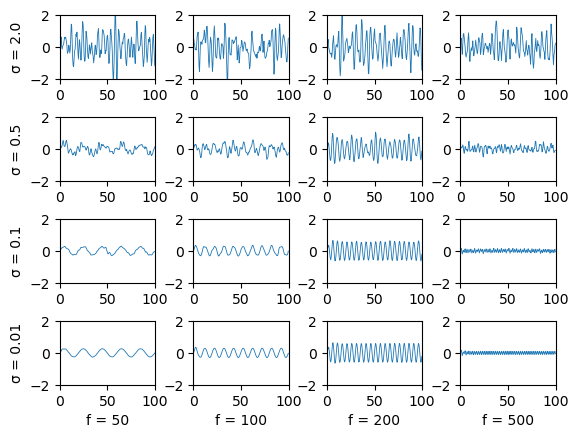

In [17]:
fs = 2000
t = np.arange(0, 0.1, 1/2000)
freqs = [50, 100, 200, 500]
sigma_s = [2.0, 0.5, 0.1, 0.01]
a = [-1.265, 0.81]
b = [0.135]
fig = noisefreqplot(t,freqs,sigma_s,a,b)

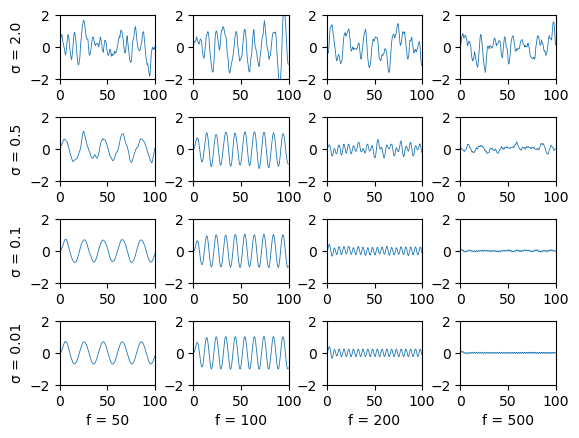

In [18]:
a = [-1.702, 0.81]
b = [0.063]
fig = noisefreqplot(t, freqs, sigma_s, a, b)

#### When you input a sinusoid, it will output a scaled version of it.

In [19]:
def energy(x):
    return np.linalg.norm(x, ord=2)**2

def power(x):
    return energy(x)/len(x)

def plotfreqresp(t, fs, a, b):
    freqs = np.linspace(0, fs/2, num=500)
    powerout = []
    for f in freqs:
        time, x = noisysignal(t = 0.1, g = "sin", tau = 0, T = 0.1, 
                                  sigma_noise = 0.025,fs = fs,f = f, 
                                  phi = 0, sigma = 0.05, n = 4,tscale = 1000, 
                                  tunits = "msces",plot = False)
        y = filterIIR(x, a, b)
        powerout.append(power(y))  
    max_idx = np.argmax(powerout)
    print("freqs[max_idx] =", freqs[max_idx])
    plot(freqs, powerout)
    plt.xlabel('Input frequency(Hz)')
    plt.ylabel('Output power')

freqs[max_idx] = 250.501002004008


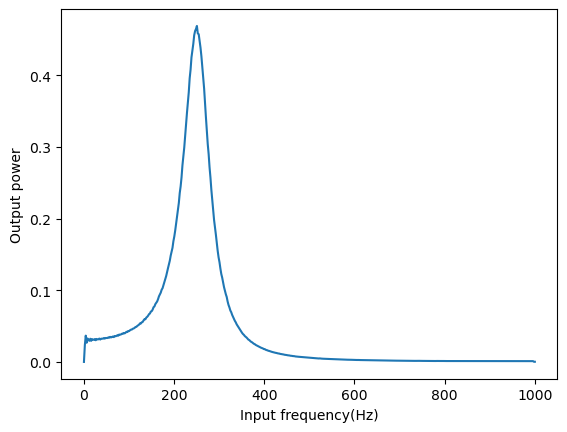

In [20]:
fs = 2000
t = np.arange(0, 0.1, 1/2000)
a = [-1.265, 0.81]
b = [0.135]
plotfreqresp(t, fs, a, b)

freqs[max_idx] = 100.2004008016032


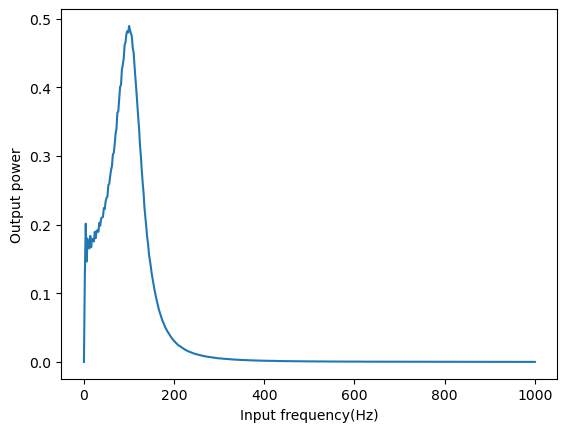

In [21]:
a = [-1.702, 0.81]
b = [0.063]
plotfreqresp(t, fs, a, b)

The bandpass filter produced by the first set of coefficients has a peak frequency of 250 Hz.

The second produces a bandpass filter with a 100 Hz peak.

## 3. The impulse response function
### 3a. Deriving the impulse response function

According to The superposition assumption, it implies that

$$
y[n] = \sum_{k=-\infty}^{\infty} x[k]\mathcal{H}(\delta[n-k])
$$

If we set that

$$
\mathcal{H}(\delta[n]) = h[n]
$$

In other words, the system response to an impulse and utilize time-invariance assumption, thus we can get that:

$$
y[n] = \mathcal{H}(x[n]) = \sum_{k=-\infty}^{\infty} x[k] h[n-k]
$$

We have to admit that it is so necessary for the time-invariance assumption, since we hade assumed that regardless of when an impulse happens, the system's reaction is always the same.


### 3b. Impulse responses

Plot the impulse responses for the systems used thus far. How can you interpret the impulse response functions in terms of a weighted average to explain the system response?

In [22]:
fs = 2000
t = np.arange(0, 0.025, 1/2000)
x = np.zeros(len(t)) 
x[0] = 1.0
print(x[0])

1.0


#### Moving average -- Low pass

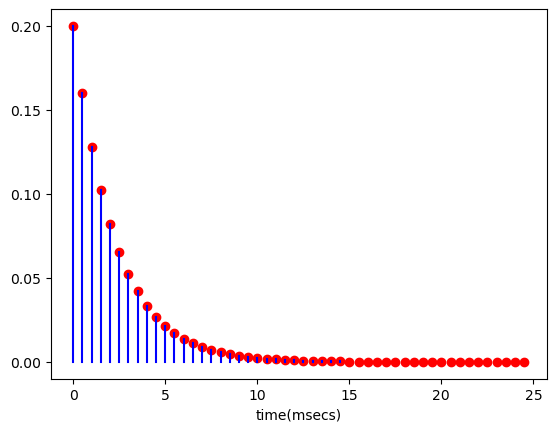

In [23]:
lam = 0.8
y = filterIIR(x, a = [-lam], b = [1-lam])
for i in range(0, len(y)):
    plt.scatter(1000 * t[i], y[i], color='r',marker='o')
    plt.plot([1000 * t[i],1000 * t[i]],[0,y[i]],color='b',linestyle='-')

plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 25.0001, 5)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(0, 0.20001, 0.05)
plt.yticks(my_y_ticks)
plt.show()

#### Low pass

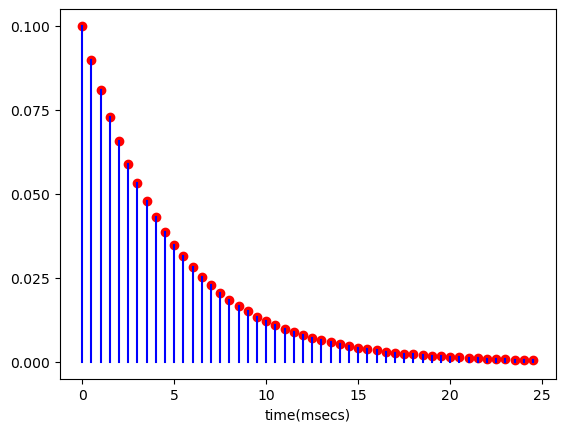

In [24]:
y = filterIIR(x, a = [-0.9], b = [0.1])
for i in range(0, len(y)):
    plt.scatter(1000 * t[i], y[i], color='r',marker='o')
    plt.plot([1000 * t[i],1000 * t[i]],[0,y[i]],color='b',linestyle='-')

plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 25.001, 5)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(0, 0.10001, 0.025)
plt.yticks(my_y_ticks)
plt.show()

#### High pass

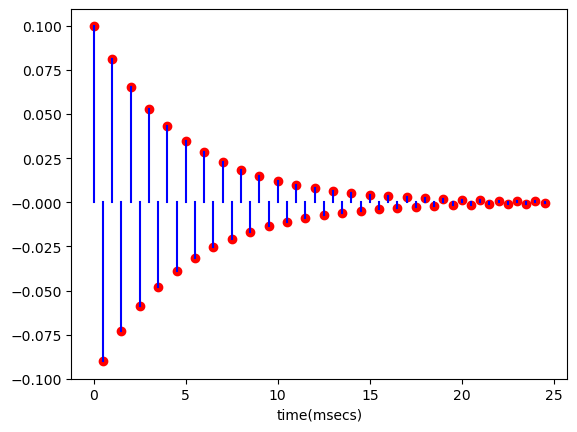

In [25]:
y = filterIIR(x, a = [0.9], b = [0.1])
for i in range(0, len(y)):
    plt.scatter(1000 * t[i], y[i], color='r',marker='o')
    plt.plot([1000 * t[i],1000 * t[i]],[0,y[i]],color='b',linestyle='-')

plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 25.001, 5)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(-0.10001, 0.10001, 0.025)
plt.yticks(my_y_ticks)
plt.show()

#### Bandpass 1

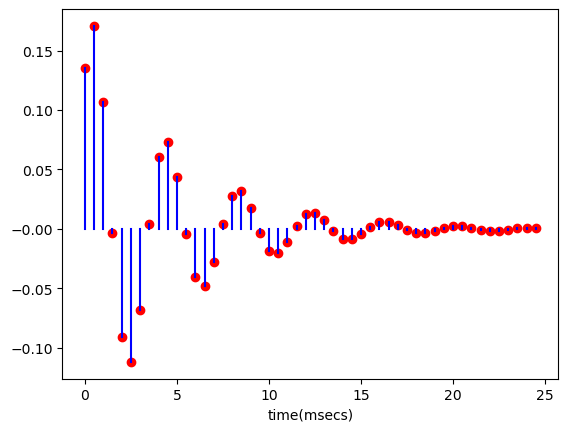

In [26]:
y = filterIIR(x, a = [-1.265, 0.81], b = [0.135])
for i in range(0, len(y)):
    plt.scatter(1000 * t[i], y[i], color='r',marker='o')
    plt.plot([1000 * t[i],1000 * t[i]],[0,y[i]],color='b',linestyle='-')

plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 25.001, 5)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(-0.10001, 0.15001, 0.05)
plt.yticks(my_y_ticks)
plt.show()

#### Bandpass 2

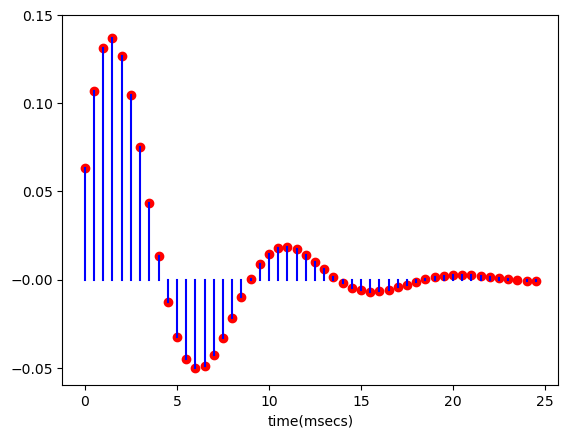

In [27]:
y = filterIIR(x, a = [-1.702, 0.81], b = [0.063])
for i in range(0, len(y)):
    plt.scatter(1000 * t[i], y[i], color='r',marker='o')
    plt.plot([1000 * t[i],1000 * t[i]],[0,y[i]],color='b',linestyle='-')

plt.xlabel('time(msecs)')
my_x_ticks = np.arange(0, 25.001, 5)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(-0.05001, 0.15001, 0.05)
plt.yticks(my_y_ticks)
plt.show()

The output sample is a linear combination of the prior samples at each sample. As we can see, the weighted average of the samples taken during the past 10 to 15 ms is successfully reduced by the moving average and low pass filters. Slower waveforms will often cancel out due to the high pass filter's alternating of positive and negative values, but high frequencies that coincide with the alternation will be maintained. The behavior of band pass filters is comparable, with the exception being the frequency range that is passed.

### 3c. TODO for next year

Given an unknown system, can you predict its output to any response?
#### Answer

I think that combining high-pass and low-pass filters with various coefficients allows one to forecast the output, where the ratio of the output defines how smooth the waveform will be after the filter.

## 4. Filtering with convolution
### 4a. Implementing convolution 

In [28]:
def convolve(x,h=[1],h0=1):
    y=[]
    for i in range(len(x)):
        yn=0
        if h0==1:
            for j in range(0,i+1):
                if (i-j)>(len(h)-1):
                    hij=0
                else:
                    hij=h[i-j]
                yn+=x[j]*hij
            y.append(yn)
        else:
            for j in range(0,i+1):
                if abs(i-j)>(len(h)-1):
                    hij=0
                elif i-j<0:
                    hij=h[j-i]
                else:
                    hij=h[i-j]
                yn+=x[j]*hij
            y.append(yn)
    return np.array(y)

#### Use bandpass1 to test 

In [64]:
fs = 2000
t = np.arange(0, 0.1, 1/fs)
x = np.zeros(len(t)) 
x[0] = 1.0
a = [-1.265, 0.81]
b = [0.135]
h = filterIIR(x, a, b)
x = 2 * np.random.rand(len(t)) - 1
yiir = filterIIR(x,a,b)

In [30]:
yh = convolve(x, h)

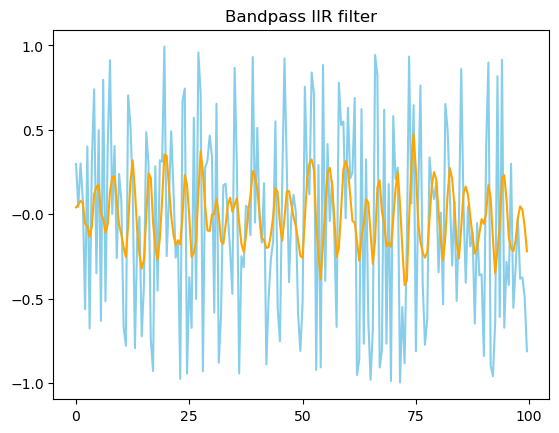

In [31]:
plt.plot(1000 * t, x, color = "skyblue")
plt.plot(1000 * t, yiir, color = "orange")
plt.title("Bandpass IIR filter")
my_x_ticks = np.arange(0, 100.001, 25)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(-1.001, 1.001, 0.5)
plt.yticks(my_y_ticks)
plt.show()

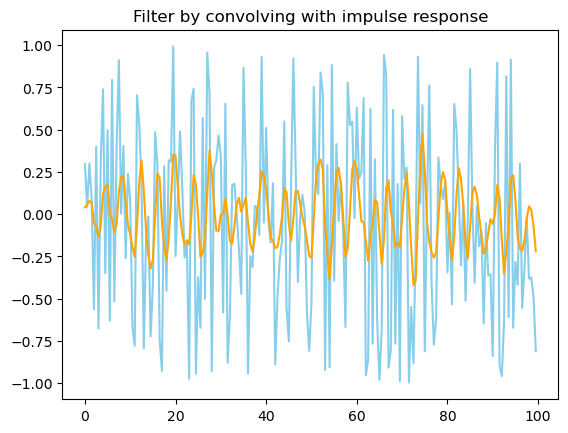

In [32]:
plt.plot(1000 * t, x, color = "skyblue")
plt.plot(1000 * t, yh, color = "orange")
plt.title("Filter by convolving with impulse response")
plt.show()

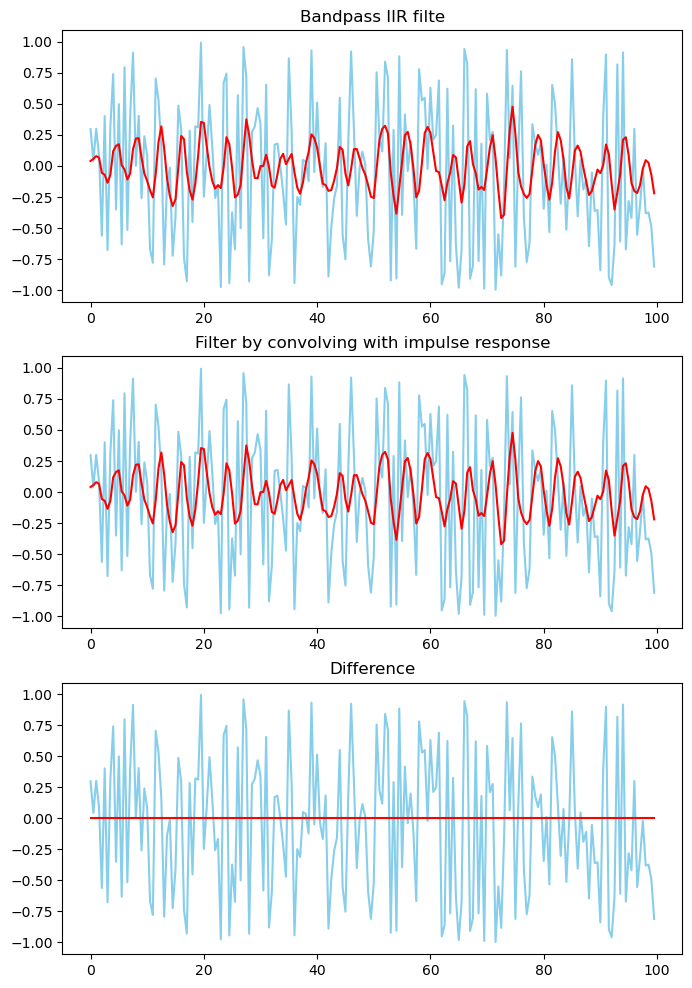

In [33]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].set_title('Bandpass IIR filte')
axs[0].plot(1000 * t, x, color = "skyblue")
axs[0].plot(1000 * t, yiir, color = "r")
axs[1].set_title('Filter by convolving with impulse response')
axs[1].plot(1000 * t, x, color = "skyblue")
axs[1].plot(1000 * t, yh, color = "r")
axs[2].set_title('Difference')
axs[2].plot(1000 * t, x, color = "skyblue")
axs[2].plot(1000 * t, yh-yiir, color = "r")
plt.show()

In [34]:
sum(yh - yiir)

-1.960237527853792e-16

### 4b. FIR filtering

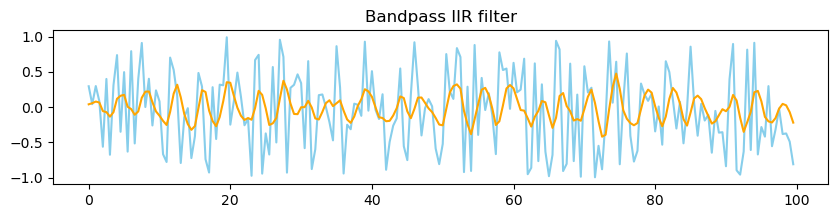

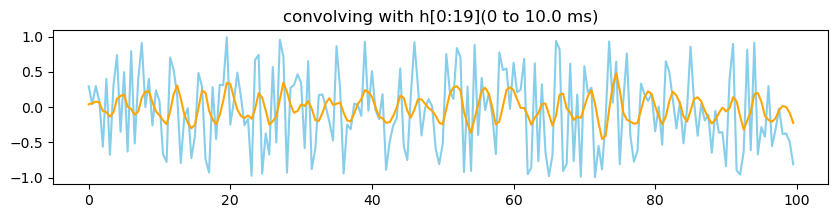

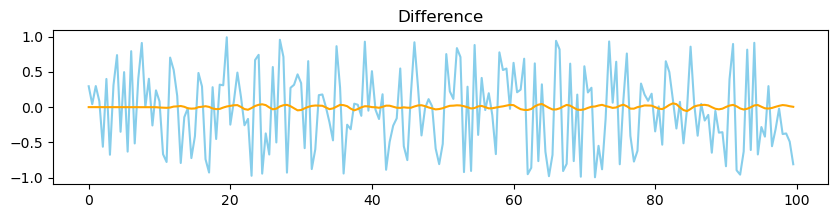

In [35]:
tlim = 0.01
K = next(i for i, t_i in reversed(list(enumerate(t))) if t_i < tlim)
hfir = h[0:K]
yfir = convolve(x, h = hfir)
plt.figure(figsize=(10,2))
plt.plot(1000 * t, x, color = "skyblue")
plt.plot(10**3 * t, yiir, color = "orange")
plt.title("Bandpass IIR filter".format(K, 1000 * tlim))

plt.figure(figsize=(10,2))
plt.plot(1000 * t, x, color = "skyblue")
plt.plot(10**3 * t, yfir, color = "orange")
plt.title("convolving with h[0:{}](0 to {} ms)".format(K, 1000 * tlim))
plt.show()

plt.figure(figsize=(10,2))
plt.plot(1000 * t, x, color = "skyblue")
plt.plot(10**3 * t, yh - yfir, color = "orange")
plt.title("Difference".format(K, 1000 * tlim))
plt.show()

In [36]:
sum(yfir - yiir)

-0.1736361353723345

### Filter with a Gabor function

In [37]:
import librosa
import librosa.display

def gabor_a(t,fs,sigma=1.0,f=1.0,phi=0.0):
    return gabor(t,sigma,f,phi)/ gabor_norm(fs,sigma,f,phi)
def gabor(t,sigma,f,phi):#calcuate g without normalizing constant
    return math.exp(-pow(t,2)/(2*pow(sigma,2)))*math.cos(2*math.pi*f*(t)+phi)
def gabor_norm(fs,sigma=1.0,f=1.0,phi=0.0):#calcuate normalizing constant
    sum_g=[]
    for index in range(-fs,fs):
        t=(index)/fs
        sum_g.append(gabor(t,sigma,f,phi))
    return np.linalg.norm(sum_g)

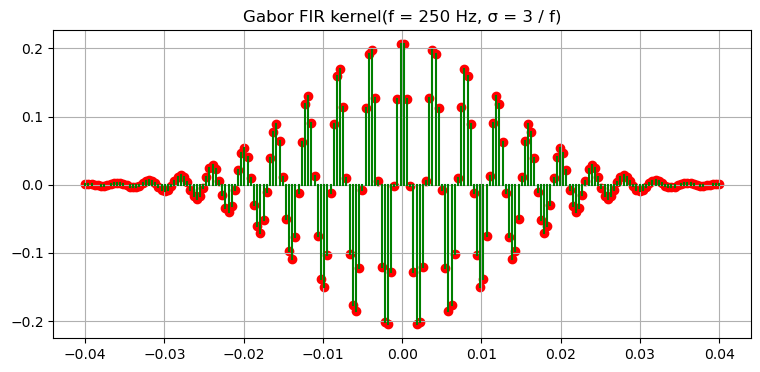

In [38]:
fs = 2000
f = 250
sigma = 3 / f
p = np.linspace(-0.04,0.04,200)
q = np.vectorize(gabor_a)(p, fs = fs, sigma = 3/f, f = f)
plt.figure(figsize = (9, 4))
for j in range(len(q)):
    plt.scatter(p[j],q[j], color='r')
    plt.plot([p[j],p[j]],[0,q[j]],color='g')
plt.title("Gabor FIR kernel(f = 250 Hz, σ = 3 / f)")
plt.grid()
plt.show()

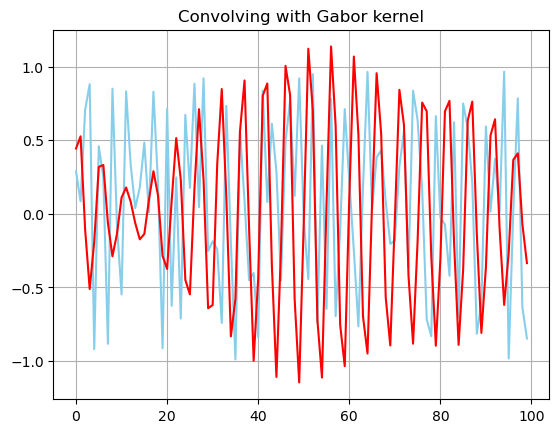

In [44]:
p = np.linspace(-0.04,0.04,100)
q = np.vectorize(gabor_a)(p, fs = fs, sigma = 3/f, f = f)
h_value=q.copy()
The_index=np.where(np.array(h_value)==max(h_value))
noise_value=np.random.uniform(-1,1,200)
q_new=convolve(noise_value,h_value,h0=The_index)
plt.plot(noise_value[100:200], color = "skyblue")
plt.plot(q_new[100:200], color = "r")
plt.title("Convolving with Gabor kernel")
plt.grid()
plt.show()

### 4c. Using matched filters to detect signals in noise

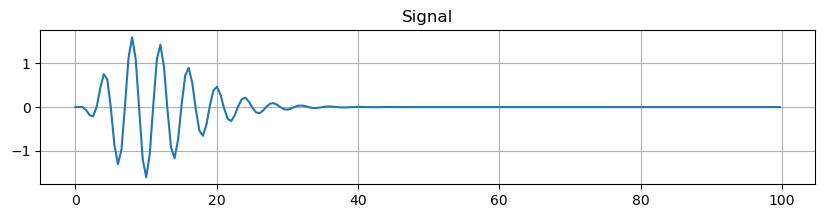

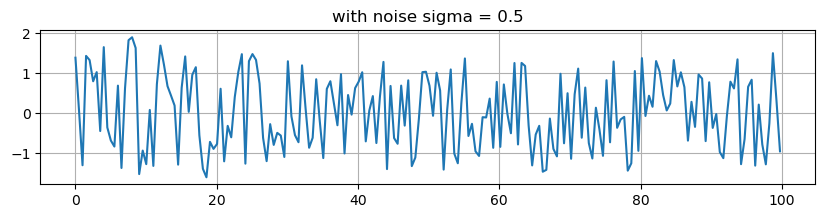

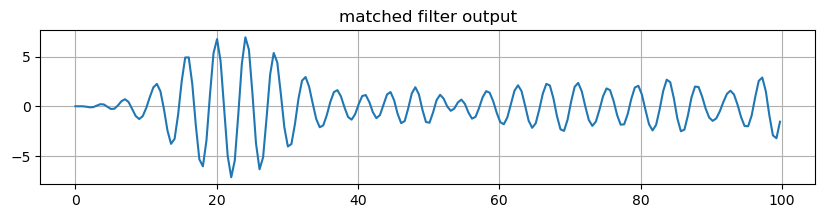

In [40]:
import A3b
A3b.matched_filter_fig(fs = 2000, t1 = 0.1, f1 = 250, sig = 0.5)

I think that it does not need repeated tests in order to demonstrate a more distinct signal waveform, making it more efficient than threshold detection. On the other hand, for threshold detection to work best, many tests must be performed in order to determine a certain value.